In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#Loading training set into dataframe
df = pd.read_csv('./data/TOC_WF_LMX_4K.csv')
df.head()

,Depth/Thickness(m),GR(API),AC(us/m),RT(ohm×m),TOC(%),Journal,Author,Well,Area,DOI1,DOI2,Unnamed: 11,Unnamed: 12
0,2490.000,29.06525,65.23841,78.04103,1.72428,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2021",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN
1,2490.125,30.90459,66.23507,99.68520,1.58637,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2022",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN
2,2490.250,33.11180,67.23173,112.66383,1.58637,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2023",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN
3,2490.375,32.74393,68.22838,116.16438,1.51742,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2024",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,`
4,2490.500,31.27246,67.23173,102.78249,1.86219,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2025",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN


In [3]:
df = df.drop(columns='Depth/Thickness(m)')
df = df.drop(columns='Journal')
df = df.drop(columns='Author')
df = df.drop(columns='Well')
df = df.drop(columns='Area')
df = df.drop(columns='DOI1')
df = df.drop(columns='DOI2')
df = df.drop(columns='Unnamed: 11')
df = df.drop(columns='Unnamed: 12')

In [4]:
#This is an example, taking TOC as label to predict
label_data = df['TOC(%)']
train_data = df.drop('TOC(%)', axis=1) # we don't need it in this project
label_data.shape, train_data.shape

((4015,), (4015, 3))

In [5]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [6]:
#Normalizing dataset
new_train = normalize(train_data,train_data.columns)
new_train

,GR(API),AC(us/m),RT(ohm×m)
0,0.048273,0.171642,0.049639
1,0.051515,0.174820,0.063547
2,0.055404,0.177998,0.071888
3,0.054756,0.181176,0.074137
4,0.052163,0.177998,0.065538
...,...,...,...
4010,0.454709,0.187245,0.005050
4011,0.419847,0.186679,0.004146
4012,0.384985,0.189512,0.005898
4013,0.447737,0.190079,0.005459


In [7]:
label_data.isnull().values.any()
new_train.isnull().values.any()

False

In [8]:
#Test Nan and fill with mean
for column in list(new_train.columns[ new_train.isnull().sum() > 0]):
    mean_val = new_train[column].mean()
    new_train[column].fillna(mean_val, inplace=True)

In [9]:
training = np.array(new_train)
labeling = np.array(label_data)

In [10]:
training = torch.tensor(training, dtype=torch.float32)
labeling = torch.tensor(labeling, dtype=torch.float32)

In [11]:
labeling = labeling.unsqueeze(-1)

In [12]:
labeling.shape, training.shape

(torch.Size([4015, 1]), torch.Size([4015, 3]))

In [13]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [49]:
class ParaNet(nn.Module):
    def __init__(self):
        super(WellLogNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 3)
        self.conv_res = nn.Conv1d(3, 256, kernel_size=1) # Channel adjust

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1) # inputx3x1
        
        residual = x # add residual, inputx3x1
        residual = F.relu(self.conv_res(x)) # inputx256x1
        # residual = residual.squeeze(2) # inputx256

        x = F.relu(self.conv1(x)) # inputx64x1
        x = F.relu(self.conv2(x)) # inputx128x1
        x = F.relu(self.conv3(x)) # inputx256x1
        x = x + residual # residual binding
        x = F.adaptive_avg_pool1d(x, 1).squeeze(1)
        x = self.fc1(x)
        return x

class WellLogNet(nn.Module):
    def __init__(self):
        super(WellLogNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 3)
        self.conv_res = nn.Conv1d(3, 256, kernel_size=1) # Channel adjust

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1) # inputx3x1
        
        residual = x # add residual, inputx3x1
        residual = F.relu(self.conv_res(x)) # inputx256x1
        # residual = residual.squeeze(2) # inputx256

        x = F.relu(self.conv1(x)) # inputx64x1
        x = F.relu(self.conv2(x)) # inputx128x1
        x = F.relu(self.conv3(x)) # inputx256x1
        x = x + residual # residual binding
        x = F.adaptive_avg_pool1d(x, 1).squeeze(2)
        x = self.fc1(x)
        return x

class RONet(nn.Module):
    def __init__(self):
        super(RONet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 1)
        self.conv_res = nn.Conv1d(3, 256, kernel_size=1) # Channel adjust

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1)

        residual = x # add residual
        residual = F.relu(self.conv_res(x))
        # residual = residual.unsqueeze(2)

        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x + residual # residual binding
        x = F.adaptive_avg_pool1d(x, 1).squeeze(2)
        x = self.fc1(x)
        return x

class BiasNet(nn.Module):
    def __init__(self):
        super(BiasNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 1)
        self.conv_res = nn.Conv1d(3, 256, kernel_size=1) # Channel adjust

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1)

        residual = x # add residual
        residual = F.relu(self.conv_res(x))
        # residual = residual.unsqueeze(2)
        
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x + residual # residual binding
        x = F.adaptive_avg_pool1d(x, 1).squeeze(2)
        x = self.fc1(x)
        return x


class PasseyNet(nn.Module):
    def __init__(self):
        super(PasseyNet, self).__init__()
        self.well_log_net = WellLogNet()
        self.ro_net = RONet()
        self.bias_net = BiasNet()

    def forward(self, x):
        well_log_matrix = self.well_log_net(x)
        ro_matrix = self.ro_net(x)
        bias_matrix = self.bias_net(x)
        
        output = torch.matmul(torch.matmul(x, well_log_matrix.T), 
                              torch.pow(10.0, ro_matrix)) + bias_matrix
        return output

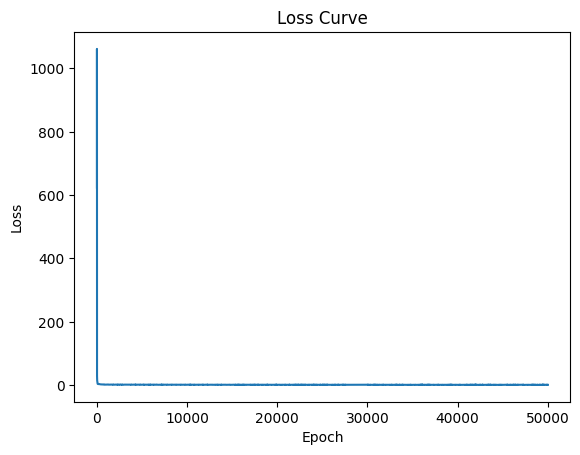

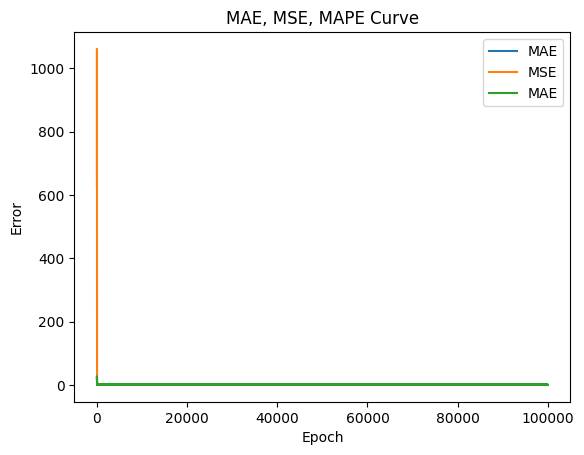

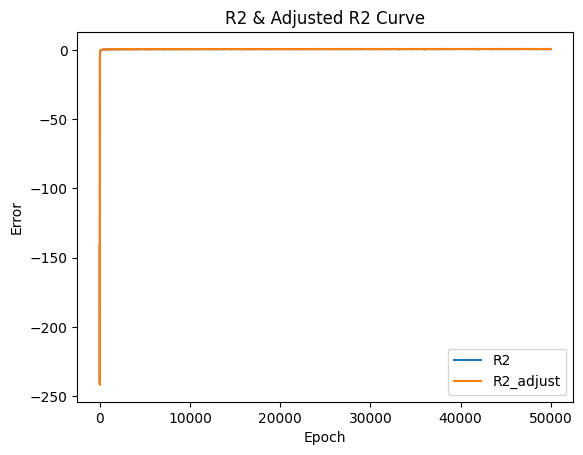

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 
from sklearn.model_selection import KFold
import torch

torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model = PasseyNet()
model.to(device)

x = training.to(device)
y = labeling.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 存储loss、mae、mse、R2、mape
loss_list = []
mae_list = []
mse_list = []
r2_list = []
r2_adjust_list = []
mape_list = []

for i in range(100):

    kf = KFold(n_splits=5, shuffle=True, random_state=42) # 设置为5-fold

    for fold ,(train_idx, val_idx) in enumerate(kf.split(training)):

        # 划分训练集和验证集
        train_x, train_y = x[train_idx], y[train_idx]
        val_x, val_y = x[val_idx], y[val_idx]

        for epoch in range(100):

            # 训练
            output = model(train_x)

            output = output.cpu() # 将output移回CPU
            label = train_y.cpu() # 将label移回CPU
            
            # forward-backward pass
            loss = criterion(output, label)  
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()

            # 验证
            with torch.no_grad():
                val_output = model(val_x)
                val_output = val_output.cpu()
                val_y = val_y.cpu()
                val_loss = criterion(val_output, val_y)

                val_pred = val_output.detach().numpy()
                val_true = val_y.detach().numpy()

                val_mae = mean_absolute_error(val_true, val_pred)
                val_mse = mean_squared_error(val_true, val_pred)

                val_r2 = r2_score(val_true, val_pred)
                val_mape = mean_absolute_percentage_error(val_true, val_pred)

                val_adjust_r2 = 1-((1-val_r2)*(len(val_x)-1))/(len(val_x)-6-1)

                # 打印结果  
                # print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, R2: {val_r2:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, MAPE: {val_mape:.4f}')
        
            # 存储loss、mae和mse
            loss_list.append(val_loss.item())
            mae_list.append(val_mae)
            mse_list.append(val_mse)
            r2_list.append(val_r2)
            r2_adjust_list.append(val_adjust_r2)
            mae_list.append(val_mape)
    
# 绘制K折验证结果        
plt.plot(loss_list)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 绘制MAE、MSE、MAPE曲线
plt.plot(mae_list, label='MAE')
plt.plot(mse_list, label='MSE')
plt.plot(mae_list, label='MAE')
plt.title('MAE, MSE, MAPE Curve')  
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

# 绘制R2、R2_adjust曲线
plt.plot(r2_list, label='R2')
plt.plot(r2_adjust_list, label='R2_adjust')
plt.title('R2 & Adjusted R2 Curve')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [52]:
#Loading training set into dataframe
test_df = pd.read_csv('./data/TOC_WF_LMX_4K.csv')
test_df.head()

,Depth/Thickness(m),GR(API),AC(us/m),RT(ohm×m),TOC(%),Journal,Author,Well,Area,DOI1,DOI2,Unnamed: 11,Unnamed: 12
0,2490.000,29.06525,65.23841,78.04103,1.72428,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2021",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN
1,2490.125,30.90459,66.23507,99.68520,1.58637,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2022",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN
2,2490.250,33.11180,67.23173,112.66383,1.58637,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2023",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN
3,2490.375,32.74393,68.22838,116.16438,1.51742,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2024",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,`
4,2490.500,31.27246,67.23173,102.78249,1.86219,Oil & Gas Geology (Chinese Edition)/Marine Pet...,"Shen et al., 2021/Nie et., 2025",N201,Changning/South Sichuan,10.11743/ogg20210109,10.3969/j.issn.1672-9854.2021.01.005,NaN,NaN


In [53]:
test_df = test_df.drop(columns='Depth/Thickness(m)')
test_df = test_df.drop(columns='Journal')
test_df = test_df.drop(columns='Author')
test_df = test_df.drop(columns='Well')
test_df = test_df.drop(columns='Area')
test_df = test_df.drop(columns='DOI1')
test_df = test_df.drop(columns='DOI2')
test_df = test_df.drop(columns='Unnamed: 11')
test_df = test_df.drop(columns='Unnamed: 12')

In [54]:
test_df.shape

(4015, 4)

In [55]:
test_df_last_30 = test_df.tail(30)
test_df_last_30

,GR(API),AC(us/m),RT(ohm×m),TOC(%)
3985,360.59175,69.77638,10.33407,4.59467
3986,340.80912,69.77638,8.65369,4.69058
3987,321.02649,70.13181,8.20503,5.40995
3988,301.24386,69.24324,9.45663,5.74566
3989,281.46123,69.95410,7.91892,5.69770
3990,261.67859,69.06553,8.96634,5.21812
3991,241.89596,69.95410,10.70744,4.73854
3992,222.11333,70.48724,8.50147,4.93037
3993,202.33070,69.77638,10.51910,5.07425
3994,194.41764,70.13181,9.62594,4.73854


In [56]:
#This is an example, taking TOC as label to predict
test_label = test_df_last_30['TOC(%)']
test_train = test_df_last_30.drop('TOC(%)', axis=1) # we don't need it in this project
test_label.shape, test_train.shape

((30,), (30, 3))

In [57]:
#Normalizing dataset
normalized_test_train = normalize(test_train, test_train.columns)
normalized_test_train

,GR(API),AC(us/m),RT(ohm×m)
3985,1.000000,0.200000,0.317041
3986,0.880952,0.200000,0.144492
3987,0.761905,0.280000,0.098422
3988,0.642857,0.080000,0.226942
3989,0.523810,0.240001,0.069043
3990,0.404762,0.040001,0.176597
3991,0.285714,0.240001,0.355381
3992,0.166667,0.360001,0.128862
3993,0.047619,0.200000,0.336041
3994,0.000000,0.280000,0.244327


In [58]:
#Test Nan and fill with mean
for column in list(normalized_test_train.columns[ normalized_test_train.isnull().sum() > 0]):
    mean_val = normalized_test_train[column].mean()
    normalized_test_train[column].fillna(mean_val, inplace=True)

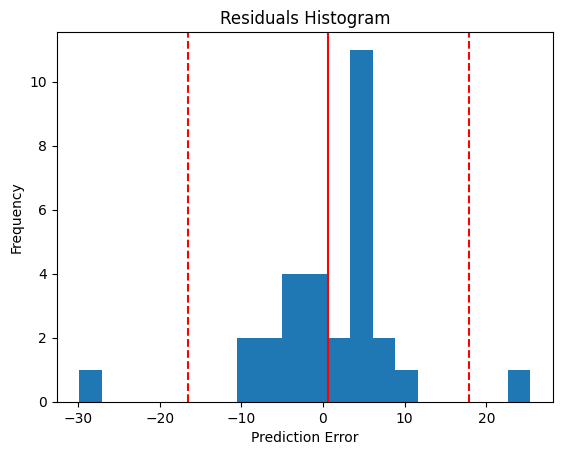

In [59]:
# 需要传入Tensor 
X_test = normalized_test_train.values # 转为numpy数组
X_test = torch.Tensor(X_test).to(device) # 转为Tensor


# 切换到训练模式
model.train() 

# 预测值 
y_pred = model(X_test)
y_pred = y_pred.cpu().detach().numpy()

# 真实值
y_true = test_label 

# 残差 
y_true = y_true.ravel()  
y_pred = y_pred.ravel()
resid = y_true - y_pred

# 绘图
plt.hist(resid, bins=20)
plt.title('Residuals Histogram')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

# 均值和标准差
mean = resid.mean()
stddev = resid.std()

# 绘制竖直线
plt.axvline(mean, color='r')
plt.axvline(mean + 2*stddev, color='r', linestyle='--')
plt.axvline(mean - 2*stddev, color='r', linestyle='--')

plt.show()

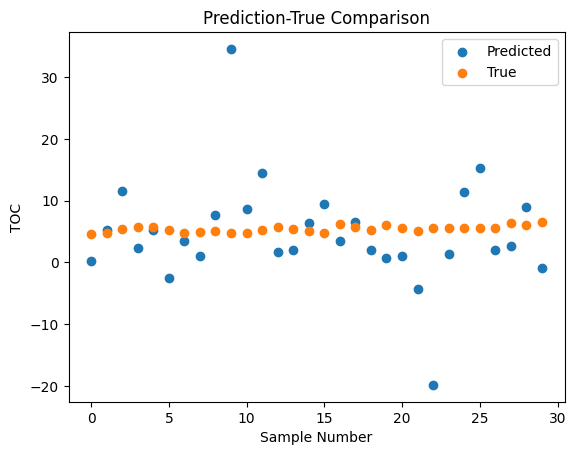

In [60]:
# 绘制预测值实际值差距图

# well_name = test_df_last_30['井名']

x = range(len(y_pred))

plt.scatter(x, y_pred, label='Predicted')
plt.scatter(x, y_true, label='True')

plt.title('Prediction-True Comparison')
plt.ylabel('TOC')
plt.xlabel('Sample Number')
plt.legend()
plt.show()